In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In [3]:
config_name = 'tunnel'
conf = load_conf(config_name)

In [4]:
# Contains tuple of:
# - params
# - data_pot
# - data_psi2[ |Φ|, Re{Φ}, Im{Φ} ]
# - data_obs[t, prob, prob, E, xmoy, x2moy, pmoy, p2moy]
E = 1283.2037962506  # Energy of particle with 0 potential
dataset = run_with_params(
    config_name,
    gen_variations({
        'V0': [E/2, E, E*1.5]
    })
)

Running simulations... Done 3/3


In [5]:
def extract(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray]) -> tuple[np.ndarray, ...]:
    params, data_pot, data_psi2, data_obs = dataset
    x = data_pot[:,0]
    t = data_obs[:,0]
    prob_left = data_obs[:,1]
    prob_right = data_obs[:,2]
    H_moy = data_obs[:,3]
    x_moy = data_obs[:,4]
    x2_moy = data_obs[:,5]
    p_moy = data_obs[:,6]
    p2_moy = data_obs[:,7]

    delta_x = np.sqrt(x2_moy - x_moy**2)
    delta_p = np.sqrt(p2_moy - p_moy**2)

    return x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p

In [6]:
# def extract(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray]) -> tuple[np.ndarray, ...]:
#     params, data_pot, data_psi2, data_obs = dataset
#     x = data_pot[:,0]
#     t = data_obs[:,0]
#     prob_left = data_obs[:,1]
#     prob_right = data_obs[:,2]
#     H_moy = data_obs[:,3]
#     x_moy = data_obs[:,4]
#     x2_moy = data_obs[:,5]
#     p_moy = data_obs[:,6]
#     p2_moy = data_obs[:,7]

#     delta_x = np.sqrt(x2_moy - x_moy**2)
#     delta_p = np.sqrt(p2_moy - p_moy**2)

#     return x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p

# Plots position, proba

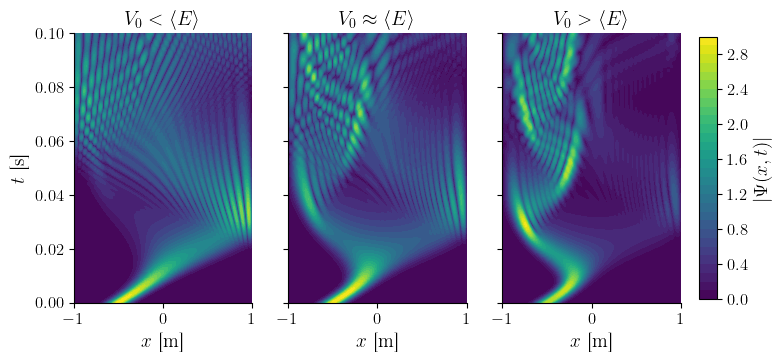

In [7]:
%matplotlib inline

fig, feur = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
ax: list[plt.Axes] = feur
magic = [r'<', r'\approx', r'>']
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
    x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
        extract((params, data_pot, data_psi2, data_obs))
    X, Y = np.meshgrid(x, t)
    im = ax[i].contourf(X, Y, np.sqrt(data_psi2[:,::3]), levels=32)
    ax[i].set_xlabel(r'$x$ [m]')
    ax[i].set_title(f'$V_0 {magic[i]} \\langle E \\rangle$')

ax[0].set_ylabel(r'$t$ [s]')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax).set_label(r'$|\Psi(x,t)|$')

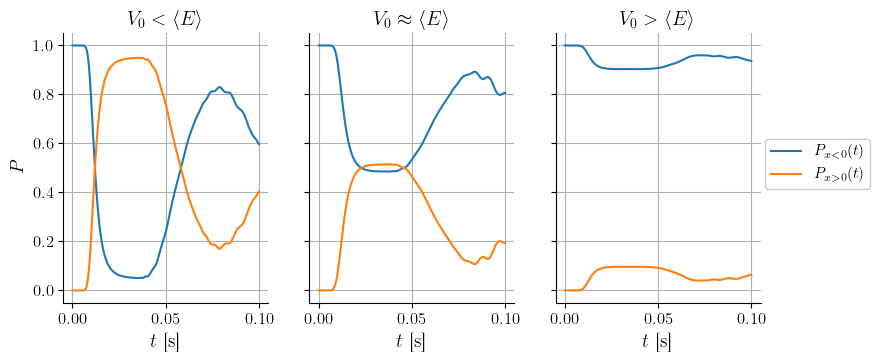

In [8]:
%matplotlib inline

fig, feur = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
ax: list[plt.Axes] = feur
magic = [r'<', r'\approx', r'>']
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
    x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
        extract((params, data_pot, data_psi2, data_obs))
    if i==0:
        label_left = r'$P_{x<0}(t)$'
        label_right = r'$P_{x>0}(t)$'
    else:
        label_left, label_right = None, None
    ax[i].plot(t, prob_left, label=label_left)
    ax[i].plot(t, prob_right, label=label_right)
    ax[i].set_xlabel(r'$t$ [s]')
    ax[i].set_title(f'$V_0 {magic[i]} \\langle E \\rangle$')
    ax[i].grid()

ax[0].set_ylabel(r'$P$')
# fig.subplots_adjust(right=0.8)
fig.legend(bbox_to_anchor=(1.03,0.6))
# cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.75])
# fig.colorbar(im, cax=cbar_ax).set_label(r'$|\Psi(x,t)|$')

In [9]:
# for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
#     x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
#         extract((params, data_pot, data_psi2, data_obs))
#     plt.plot(t, prob_left, label=f'$V_0 {magic[i]} \\langle E \\rangle$' )
#     plt.plot(t, prob_right)
#     plt.xlabel(r'$t$ [s]')
#     plt.ylabel(r'$P_{x<0}(t)$')
#     plt.grid()
#     plt.legend()
#     plt.show()

# Convergence

In [10]:
def extract_at_time(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray]) -> tuple[np.ndarray, ...]:
    params, data_pot, data_psi2, data_obs = dataset
    t = data_obs[:,0]
    index = np.argmin(np.abs(t-0.03))
    # x = data_pot[:,0]
    prob_right = data_obs[:,2]
    H_moy = data_obs[:,3]

    return t[index], prob_right[index], H_moy[index]

In [17]:
Nintervals = np.linspace(500, 5000, num=15)

dataset_conv_nx = run_with_params(
    config_name,
    gen_variations({
        'V0': [E],
        'Nintervals': Nintervals
    })
)

Running simulations... Done 15/15


In [24]:
probs = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_nx):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs))
    # print(t)
    probs.append(prob)
probs = np.array(probs)

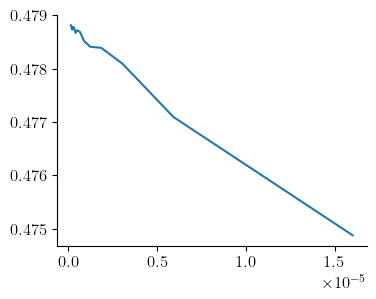

In [28]:
L = conf['xR'] - conf['xL']
dxs = L/Nintervals
plt.plot(dxs**2, probs)


In [32]:
delta_ts = np.geomspace(1e-5, 1e-2, num=4)

dataset_conv_ts = run_with_params(
    config_name,
    gen_variations({
        'V0': [E],
        'Nintervals': [512],
        'dt': delta_ts
    })
)

Running simulations... Done 4/4


exception calling callback for <Future at 0x7efd7d0ea5d0 state=finished returned NoneType>
Traceback (most recent call last):
  File "/usr/lib64/python3.11/concurrent/futures/_base.py", line 340, in _invoke_callbacks
    callback(self)
  File "/home/martingodet/Desktop/epflBA4/phys_num/PhysNum/exercice6/analysis/utils.py", line 63, in done
    print(f'\rRunning simulations... Done {count}/{len(all_params)}', end='')
  File "/home/martingodet/.local/lib/python3.11/site-packages/ipykernel/iostream.py", line 664, in write
    self._schedule_flush()
  File "/home/martingodet/.local/lib/python3.11/site-packages/ipykernel/iostream.py", line 561, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/home/martingodet/.local/lib/python3.11/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/home/martingodet/.local/lib/python3.11/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=flags,

In [33]:
probs = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_ts):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs))
    # print(t)
    probs.append(prob)
probs = np.array(probs)

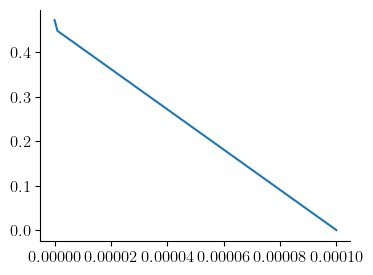

In [34]:
plt.plot(delta_ts**2, probs)

In [35]:
V0s = np.linspace(0.2, 2, num=10) * E

dataset_conv_Es = run_with_params(
    config_name,
    gen_variations({
        'V0': V0s,
        'Nintervals': [512],
        # 'dt': delta_ts
    })
)

Running simulations... Done 10/10


In [38]:
probs = []
E_moys = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_Es):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs))
    # print(t)
    probs.append(prob)
    E_moys.append(E)
probs = np.array(probs)
E_moys = np.array(E_moys)

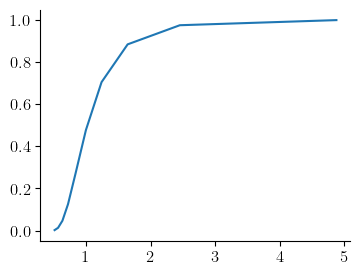

In [39]:
plt.plot(E_moys/V0s, probs)

In [9]:
# 


1322.47745382071


# Animate

In [8]:
%matplotlib qt
import matplotlib.animation as mpla

plt.figure(figsize=(8, 6))

line1, = plt.plot(data_pot[:,0], data_psi2[0,::3])
line2, = plt.plot(data_pot[:,0], data_psi2[0,1::3])
line3, = plt.plot(data_pot[:,0], data_psi2[0,2::3])
size = data_psi2.shape[0]


def animate(i) -> Any:
    idx = i % size
    line1.set_data(data_pot[:,0], data_psi2[idx,::3])
    line2.set_data(data_pot[:,0], data_psi2[idx,1::3])
    line3.set_data(data_pot[:,0], data_psi2[idx,2::3])

anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$|\Psi|^2$')
# plt.ylim(-2, 2)
plt.grid()
plt.tight_layout()